# generate_obs_hte_26_rich()

### Mathematical Specification of `generate_obs_hte_26_rich()`

The `generate_obs_hte_26_rich()` function provides a more complex and realistic observational dataset. It features 11 confounders, complex dependencies (including derived features), a low treatment rate, and a **Tweedie (zero-inflated Gamma)** outcome model.


#### 1. Confounders ($X$)
The dataset contains 11 confounders $X = (X_1, \dots, X_{11})^T$:
- $X_1$: `tenure_months`
- $X_2$: `avg_sessions_week`
- $X_3$: `spend_last_month`
- $X_4$: `age_years`
- $X_5$: `income_monthly`
- $X_6$: `prior_purchases_12m`
- $X_7$: `support_tickets_90d`
- $X_8$: `premium_user`
- $X_9$: `mobile_user`
- $X_{10}$: `urban_resident`
- $X_{11}$: `referred_user`

**Base Features Sampling:**
The base features $(X_1, X_2, X_3, X_4, X_5, X_{10})$ are sampled using a **Gaussian Copula** with the following correlation matrix:
$$\Sigma = \begin{pmatrix}
1.00 & 0.20 & 0.20 & 0.30 & 0.20 & 0.00 \\
0.20 & 1.00 & 0.45 & -0.20 & 0.30 & 0.10 \\
0.20 & 0.45 & 1.00 & -0.10 & 0.40 & 0.10 \\
0.30 & -0.20 & -0.10 & 1.00 & 0.20 & -0.10 \\
0.20 & 0.30 & 0.40 & 0.20 & 1.00 & 0.10 \\
0.00 & 0.10 & 0.10 & -0.10 & 0.10 & 1.00
\end{pmatrix}$$

**Derived Features:**
The remaining features are derived to mimic real-world behavioral dependencies:
- **Premium User ($X_8$):** $\text{logit}(P(X_8=1)) = -5.0 + 0.7 \ln(1+X_2) + 0.45 \ln(1+X_3) + 0.35 \ln(1+X_5) + 0.015 X_1$
- **Mobile User ($X_9$):** $\text{logit}(P(X_9=1)) = 1.5 - 0.03(X_4 - 35) + 0.30 X_{10} + 0.25 \ln(1+X_2)$
- **Referred User ($X_{11}$):** $\text{logit}(P(X_{11}=1)) = -1.2 - 0.02(X_1 - 12) + 0.45 X_9 + 0.20 X_{10}$
- **Prior Purchases ($X_6$):** $X_6 \sim \text{Poisson}(\lambda = \text{clip}(1.0 + 0.55 \ln(1+X_2) + 0.45 \ln(1+X_3) + 0.25 X_8, 0.1, 30.0))$
- **Support Tickets ($X_7$):** $X_7 \sim \text{Poisson}(\lambda = \text{clip}(0.6 + 0.25 \ln(1+X_2) + 0.30(1-X_8) + 0.15 \tanh(\frac{X_4 - 45}{12}), 0.05, 10.0))$

#### 2. Treatment Assignment ($D$)
The treatment $D \in \{0, 1\}$ is assigned with a target rate of **5%**:
$$P(D=1|X) = \sigma\left( \alpha_d + \text{bound}\left( f_d(X), 2.0 \right) \right)$$
where $f_d(X) = \sum_{j=1}^{11} \beta_{d,j} X_j + g_d(X)$. The nonlinear component $g_d(X)$ is:
$$g_d(X) = 0.9 \tanh\left(\ln\frac{1+X_3}{61}\right) + 0.25 \ln\frac{1+X_2}{6} \tanh\left(\frac{X_1}{24} - 1\right) + 0.35 X_8(X_{10}-0.5) + 0.30 X_9 \tanh\left(\ln\frac{1+X_2}{4}\right) + 0.25 X_{11}(1 - \tanh\frac{X_1}{36}) + 0.15 \tanh\left(\ln\frac{1+X_7}{2.5}\right) - 0.10 \tanh\left(\frac{X_4-45}{12}\right)$$

#### 3. Heterogeneous Treatment Effect ($\tau(X)$)
The treatment effect on the link (log-mean) scale is:
$$\tau(X) = 1.1 + 0.55 \tanh\left(\ln\frac{1+X_2}{6}\right) + 0.90 X_8 + 0.15 X_9 + 0.20 X_{11} - 0.45 \tanh\frac{X_1}{48} - 0.25 \tanh\frac{X_4-40}{15} + 0.15 X_{10} \tanh\left(\ln\frac{1+X_3}{61}\right) - 0.15 \tanh\left(\ln\frac{1+X_7}{2.5}\right)$$
The CATE is clipped to $[0.05, 3.0]$.

#### 4. Outcome Model ($Y$)
The outcome follows a **Tweedie (Two-part Hurdle)** model:
1. **Zero-Inflation (Participation):**
   $Y > 0$ with probability $p_{pos} = \sigma(\alpha_{zi} + \sum \beta_{zi,j} X_j + g_{zi}(X) + D \cdot \tau_{zi}(X))$
   where $\alpha_{zi} = -0.8$, and the nonlinear components are:
   $$g_{zi}(X) = 0.45 \tanh\left(\ln\frac{1+X_2}{5}\right) + 0.25 \tanh\left(\ln\frac{1+X_3}{51}\right) + 0.20 \ln(1+X_6) - 0.30 \tanh\left(\ln\frac{1+X_7}{2}\right) + 0.15 X_8 + 0.10 X_9$$
   $$\tau_{zi}(X) = 0.15 + 0.10 X_8 + 0.05 X_{11} - 0.10 \tanh\frac{X_1}{48}$$

2. **Positive Outcome (Magnitude):**
   If $Y > 0$, then $Y \sim \text{Gamma}(\text{shape} = 2.2, \text{scale} = \mu_{pos} / 2.2)$
   where $\ln(\mu_{pos}) = \sum \beta_{y,j} X_j + g_y(X) + D \cdot \tau(X)$. The baseline nonlinear part is:
   $$g_y(X) = 1.4 \tanh\frac{X_1}{24} + 0.6 \left(\ln\frac{1+X_2}{6}\right)^2 + 0.25 \ln\frac{1+X_3}{61} \ln\frac{1+X_2}{6} + 0.35 \tanh\frac{\ln(1+X_5) - \ln 4001}{1.5} - 0.45 \ln(1+X_7) + 0.20 \ln(1+X_6) \tanh\frac{X_1}{18} + 0.30 X_9 \ln\frac{1+X_2}{6} + 0.25 X_8 (X_{10}-0.5) + 0.15 X_{11} \tanh(\frac{X_1}{12}-1) - 0.20 \tanh\frac{X_4-40}{15}$$


In [1]:
from causalis.scenarios.unconfoundedness.dgp import generate_obs_hte_26_rich

data = generate_obs_hte_26_rich(return_causal_data=False, include_oracle=True)
data.head()

,y,d,tenure_months,avg_sessions_week,spend_last_month,age_years,income_monthly,prior_purchases_12m,support_tickets_90d,premium_user,mobile_user,urban_resident,referred_user,m,m_obs,tau_link,g0,g1,cate
0,0.000000,0.0,28.814654,1.0,77.936767,50.234101,1926.698301,1.0,2.0,1.0,1.0,1.0,0.0,0.047970,0.047970,1.330764,8.137981,35.177086,27.039105
1,559.364158,1.0,25.913345,3.0,53.777740,28.115859,5104.271509,3.0,0.0,1.0,1.0,0.0,1.0,0.049695,0.049695,2.190209,60.459257,584.580685,524.121427
2,26.143003,1.0,24.969929,10.0,134.764322,22.907062,5267.938255,8.0,3.0,0.0,1.0,1.0,0.0,0.077087,0.077087,1.570177,7.712855,38.297992,30.585137
3,19.283585,1.0,40.655089,5.0,59.517074,31.970490,6597.327018,3.0,2.0,1.0,1.0,1.0,0.0,0.069481,0.069481,1.933844,25.386510,189.737828,164.351318
4,0.000000,1.0,18.560899,3.0,74.370930,39.237248,4930.009628,5.0,1.0,1.0,1.0,0.0,0.0,0.047097,0.047097,1.818265,15.359250,102.433597,87.074347


In [2]:
print(f"Ground truth ATE is {data['cate'].mean()}")
print(f"Ground truth ATTE is {data[data['d'] == 1]['cate'].mean()}")

Ground truth ATE is 617.0712367740982
Ground truth ATTE is 837.4043605736649


In [3]:
from causalis.data_contracts import CausalData

causaldata = CausalData(df = data,
                        treatment='d',
                        outcome='y',
                        confounders=['tenure_months', 'avg_sessions_week', 'premium_user', 'urban_resident'])
causaldata

CausalData(df=(100000, 6), treatment='d', outcome='y', confounders=['tenure_months', 'avg_sessions_week', 'premium_user', 'urban_resident'])

In [4]:
from causalis.shared import outcome_stats
outcome_stats(causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,0.0,95015,73.966492,238.503707,0.0,0.0,0.0,7.448482,62.190137,184.701873,21396.007575
1,1.0,4985,907.471726,2545.077996,0.0,0.0,0.0,143.706288,730.651759,2269.458998,48466.747037


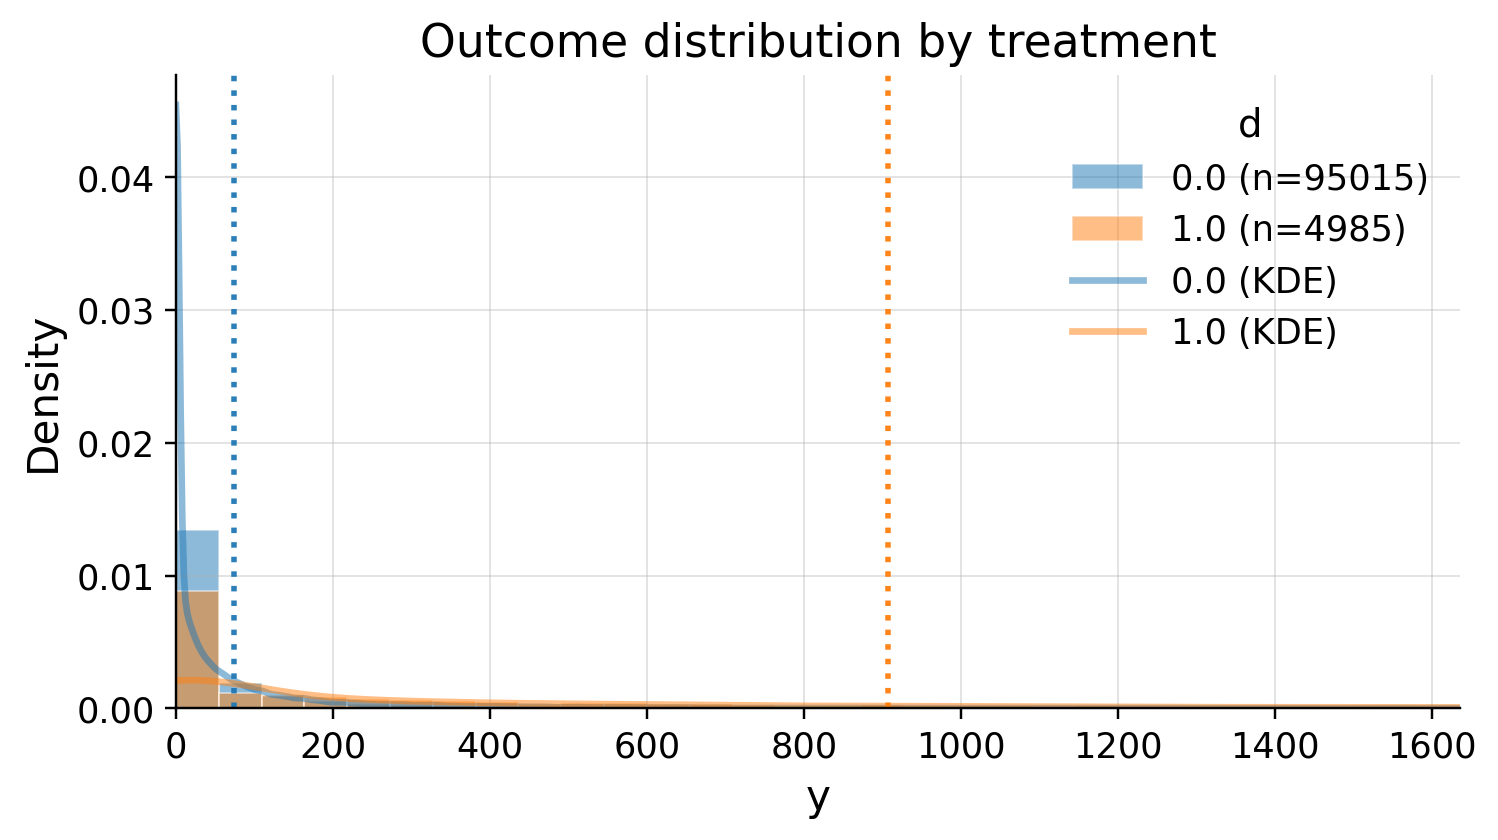

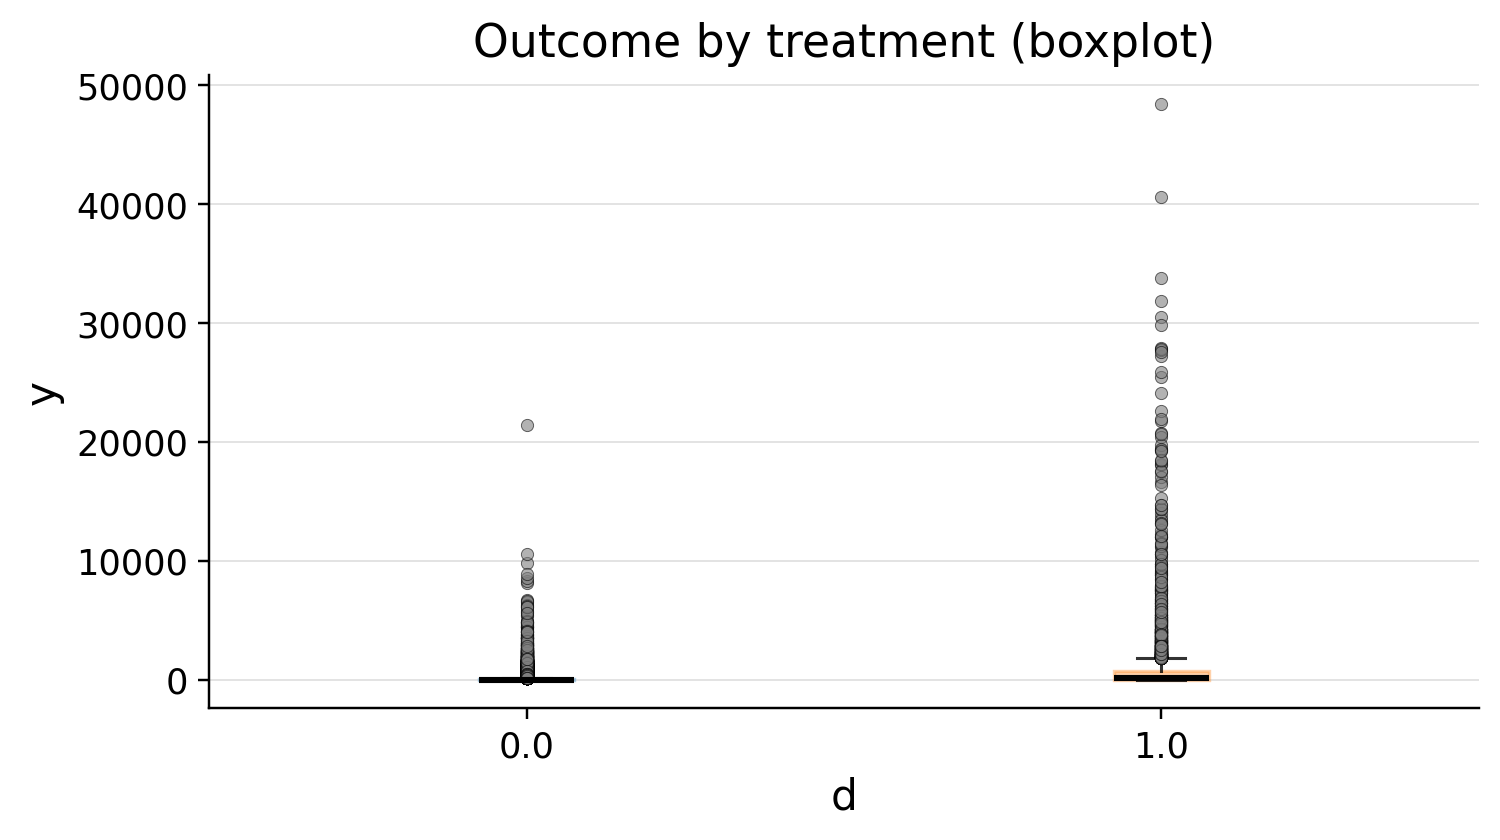

(<Figure size 1540x880 with 1 Axes>, <Figure size 1540x880 with 1 Axes>)

In [5]:
from causalis.shared import outcome_plots
outcome_plots(causaldata)
